# Assignment 1
## EECS E6691 2025 Spring

This notebook implements a simplified ***Detection Transformer (DETR)*** model in PyTorch. The goal is to
- Introduce the principles and implementations of **Transformers** (which will be discussed in greater details by upcoming lectures);
- Introduce the training and evaluation of **object detection** models;
- Familiarize the usage of **PyTorch**.

**Key References:**
- ***DETR Paper***: N. Carion, “End-to-End Object Detection with Transformers,” arXiv.org, May 26, 2020. https://arxiv.org/abs/2005.12872
- ***DETR Variants***: T. Shehzadi, “Object Detection with Transformers: A Review,” arXiv.org, Jun. 07, 2023. https://arxiv.org/abs/2306.04670.
- ***Official Code Base***: https://github.com/facebookresearch/detr.

## 0 - Setup

The following cells setup the environment.

In [1]:
%%bash

# install necessary packets
pip install opencv-python
pip install numpy matplotlib
pip install torchmetrics
pip install transformers
pip install timm

<3>WSL (10) ERROR: CreateProcessCommon:559: execvpe(/bin/bash) failed: No such file or directory


CalledProcessError: Command 'b'\n# install necessary packets\npip install opencv-python\npip install numpy matplotlib\npip install torchmetrics\npip install transformers\npip install timm\n'' returned non-zero exit status 1.

In [ ]:
%%bash

# download the dataset
wget https://www.cis.upenn.edu/~jshi/ped_html/PennFudanPed.zip .
unzip PennFudanPed.zip

In [2]:
import os
import numpy as np
import torch
import matplotlib.pyplot as plt
from PIL import Image
import cv2

from torch import nn
from torch.utils.data import Dataset, DataLoader
import torchvision
from torchvision import transforms

In [3]:
PENNFUDAN_LABEL_NAMES = [
    '__background__', 'person'
]
COCO_LABEL_NAMES = [
    '__background__', 'person', 'bicycle', 'car', 'motorcycle', 'airplane', 'bus',
    'train', 'truck', 'boat', 'traffic light', 'fire hydrant', 'N/A', 'stop sign',
    'parking meter', 'bench', 'bird', 'cat', 'dog', 'horse', 'sheep', 'cow',
    'elephant', 'bear', 'zebra', 'giraffe', 'N/A', 'backpack', 'umbrella', 'N/A', 'N/A',
    'handbag', 'tie', 'suitcase', 'frisbee', 'skis', 'snowboard', 'sports ball',
    'kite', 'baseball bat', 'baseball glove', 'skateboard', 'surfboard', 'tennis racket',
    'bottle', 'N/A', 'wine glass', 'cup', 'fork', 'knife', 'spoon', 'bowl',
    'banana', 'apple', 'sandwich', 'orange', 'broccoli', 'carrot', 'hot dog', 'pizza',
    'donut', 'cake', 'chair', 'couch', 'potted plant', 'bed', 'N/A', 'dining table',
    'N/A', 'N/A', 'toilet', 'N/A', 'tv', 'laptop', 'mouse', 'remote', 'keyboard', 'cell phone',
    'microwave', 'oven', 'toaster', 'sink', 'refrigerator', 'N/A', 'book',
    'clock', 'vase', 'scissors', 'teddy bear', 'hair drier', 'toothbrush'
]

## 1 - Dataset & Loader

Below is a dataset for the Penn-Fudan Database for Pedestrian Detection and Segmentation.

<font color="red">***NOTE:***</font> Pay special attention to how the images are transformed and how the bounding boxes are obtained. Be very careful and make modifications (if necessary) when designing your own data augmentation pipelines.

**Reference:** The code is modified from [Torchvision Object Detection Tutorial](https://pytorch.org/tutorials/intermediate/torchvision_tutorial.html).

In [4]:
class PennFudanDataset(Dataset):
    '''
    Dataset

    Args
    ----
    root -> str: root directory of the data folder
    transforms -> callable: image transformation
    '''

    def __init__(self, root, transforms):
        self.root = root
        self.transforms = transforms
        # load all image files, sorting them to ensure that they are aligned
        self.imgs = list(sorted(os.listdir(os.path.join(root, "PNGImages"))))
        self.masks = list(sorted(os.listdir(os.path.join(root, "PedMasks"))))

    def __getitem__(self, idx):
        # load images and masks
        img_path = os.path.join(self.root, "PNGImages", self.imgs[idx])
        mask_path = os.path.join(self.root, "PedMasks", self.masks[idx])
        img = Image.open(img_path).convert("RGB")
        mask = Image.open(mask_path)

        # convert the PIL Image into a numpy array
        mask = np.array(mask)
        # instances are encoded as different colors
        obj_ids = np.unique(mask)
        # first id is the background, so remove it
        obj_ids = obj_ids[1:]
        # split the color-encoded mask into a set of binary masks
        masks = mask == obj_ids[:, None, None]

        # get bounding box coordinates for each mask
        num_objs = len(obj_ids)
        boxes = []
        for i in range(num_objs):
            pos = np.where(masks[i])
            xmin = np.min(pos[1])
            xmax = np.max(pos[1])
            # original annotation use the bottom-left corner as the origin
            # here we reset it to start from top-left
            ymin = np.min(pos[0])
            ymax = np.max(pos[0])
            boxes.append([xmin, ymin, xmax, ymax])

        # convert everything into a torch.Tensor
        boxes = torch.as_tensor(boxes, dtype=torch.float32)
        # there is only one class
        labels = torch.ones((num_objs,), dtype=torch.int64)
        masks = torch.as_tensor(masks, dtype=torch.uint8)
        image_id = torch.tensor([idx])
        area = (boxes[:, 3] - boxes[:, 1]) * (boxes[:, 2] - boxes[:, 0])
        iscrowd = torch.zeros((num_objs,), dtype=torch.int64)

        # normalize the boxes
        width, height = img.size

        # construct target (labels)
        target = {}
        target["boxes"] = boxes / torch.tensor([width, height] * 2)
        target["labels"] = labels
        target["masks"] = masks
        target["image_id"] = image_id
        target["area"] = area
        target["iscrowd"] = iscrowd

        # apply transformation
        if self.transforms is not None:
            img = self.transforms(img)

        # return a tuple of (data, label)
        return img, target

    def __len__(self):
        return len(self.imgs)

In [5]:
# specify transformations
# here we only apply the basic conversions
# other necessary transformations will be added later
transform = transforms.Compose([
    # convert to tensor
    transforms.ToTensor(),
    # convert to float
    transforms.ConvertImageDtype(torch.float)
])

# construct dataset
root = './PennFudanPed'
dataset = PennFudanDataset(root, transform)

# split the dataset to train and test sets
indices = torch.randperm(len(dataset)).tolist()
train_set = torch.utils.data.Subset(dataset, indices[:-50])
test_set = torch.utils.data.Subset(dataset, indices[-50:])

len(train_set), len(test_set)

(120, 50)

**Now let's visualize some samples from the dataset.**

In [6]:
def draw_boxes(img, bbs, conf=None, names=None, color=(1., 0, 0)):
    '''
    Draw bounding boxes given a pair of data points

    Args
    ----
    image -> torch.Tensor: a 3D image tensor of shape (C, W, H)
    bbs   -> torch.Tensor: a 2D tensor of shape (n_objs, 4), each one contains
                           4 normalized box coordinates [tlx, tly, brx, bry]
    conf  -> torch.Tensor: a 1D tensor of shape (n_objs,), the ith element  
                           corresponds to the confidence score of the ith box

    Returns
    ----
    img -> numpy.array: the image with boxes overlaid
    '''

    # convert input to numpy arrays
    # need a copy of the image to function correctly
    if isinstance(img, torch.Tensor):
        img = img.numpy().transpose(1, 2, 0).copy()
    bbs = bbs.numpy()
    width, height = img.shape[:2]
    bbs = np.floor(bbs * np.array([height, width] * 2))

    # draw boxes
    for i, b in enumerate(bbs):
        # retrive the top-left & bottom-right corner
        tlx, tly, brx, bry = int(b[0]), int(b[1]), int(b[2]), int(b[3])
        # cv2 draws the boxes inplace instead of returning a new image
        cv2.rectangle(img, (tlx, tly), (brx, bry), color=color, thickness=2)
        txt = ''
        if names is not None:
            txt += names[i]
        if conf is not None:
            txt += ' ({:.2f})'.format(conf[i])
        cv2.putText(img, txt, (tlx, tly - 5), cv2.FONT_HERSHEY_SIMPLEX, 0.4, color, thickness=1)

    return img

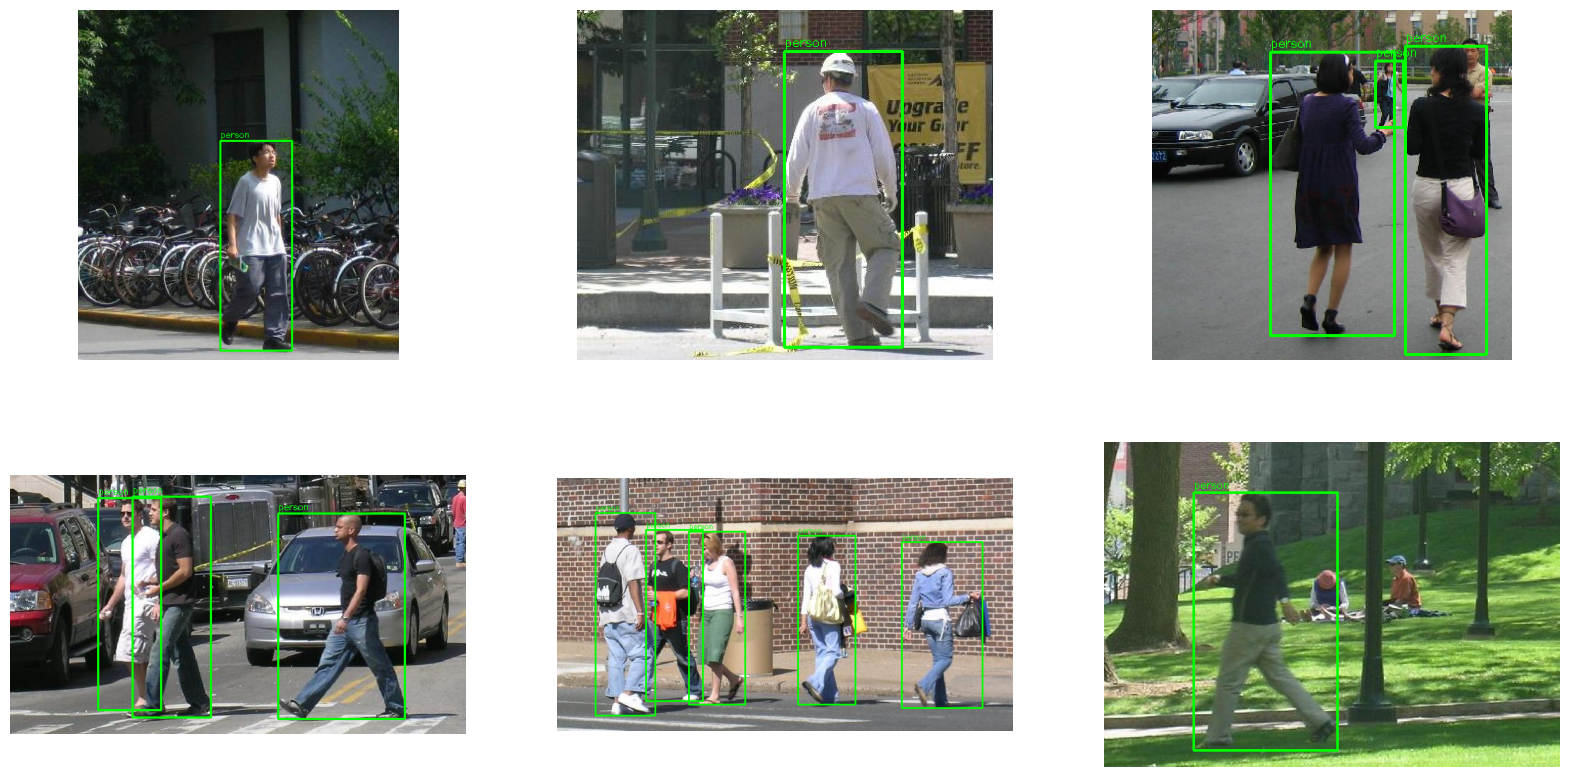

In [7]:
idx = np.random.choice(range(len(train_set)), 6, replace=False)
fig, ax = plt.subplots(2, 3, figsize=(20, 10))

for ii, i in enumerate(idx):
    Xt, yt = train_set[i]
    img = draw_boxes(Xt, yt['boxes'], color=(0, 1., 0), names=[PENNFUDAN_LABEL_NAMES[i] for i in yt['labels']])
    ax[ii//3][ii%3].imshow(img)
    ax[ii//3][ii%3].axis('off')

## 2 - Construct The Model

**Reference:** DETRCarion, Nicolas, et al. “End-to-End Object Detection with Transformers.” ArXiv.org, 28 May 2020, https://arxiv.org/abs/2005.12872.

[***Original Code Base***](https://github.com/facebookresearch/detr): This model was designed and implemented by FAIR with well-organized source codes. We will be implementing our own simpified version of that. Nevertheless, reading through parts of the code base will provide you with good understanding of what it looks like to be an industrial-level project.

<img src="https://production-media.paperswithcode.com/methods/Screen_Shot_2020-07-20_at_9.17.39_PM_ZHS2kmV.png" width="600"/>

### 2.1 - Preparation

When designing a complex model, it is usually a good practice to go bit-by-bit with every sub-module.

Here, we collect a training sample to validate the functionality of our model during development. Pay special attention to the output shape of each step.

In [8]:
# select an input image size of 380x380
# you can change this later
scale = (380, 380)

# standard mean/std for resnet model, which we will use as feature extractors
mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)

# resize & normalize the input images
t = transforms.Compose([
    transforms.Resize(scale, antialias=True),
    transforms.Normalize(mean, std)
])

# get a sample from our training set
Xt, yt = next(iter(train_set))
Xt = t(Xt)

print('Input image shape:', Xt.shape)
print('Bounding boxes:\n', yt['boxes'])

Input image shape: torch.Size([3, 380, 380])
Bounding boxes:
 tensor([[0.1985, 0.0654, 0.5729, 0.9688]])


### 2.2 - Backbone

***Feature extraction*** is a common intermediate objective shared by many deep learning tasks, where we ask the model (or a sub-moodule) to learn a ***good*** representation of the input data for some specific objectives. Indeed, this is a crucial challenge in-and-of-itself. A well estabilished solution is to utilize other models pretrained on large, general purpose datasets (e.g. [ImageNet](https://www.image-net.org)) and fine-tune it for custom purposes.

Now, let's load an ImageNet pretrained [**ResNet18**](https://arxiv.org/abs/1512.03385) and observe its structure.

In [9]:
# load a pretrained resnet18
from torchvision.models import resnet18, ResNet18_Weights
backbone = resnet18(weights=ResNet18_Weights.DEFAULT)

# list all the layers
list(enumerate(backbone.children()))

Downloading: "https://download.pytorch.org/models/resnet18-f37072fd.pth" to C:\Users\15619/.cache\torch\hub\checkpoints\resnet18-f37072fd.pth
100%|██████████| 44.7M/44.7M [00:01<00:00, 40.6MB/s]


[(0,
  Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)),
 (1,
  BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)),
 (2, ReLU(inplace=True)),
 (3,
  MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)),
 (4,
  Sequential(
    (0): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    )
    (1): BasicBlock(
      (conv1): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
      (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
      (relu): ReLU(inplace=True)
      (conv2): Conv2d(64

The ResNet18 we use here is consisted of ***10*** cascading sub-modules:
- ***Layer 0-3:*** global feature extraction
- ***Layer 4-7:*** different levels of local feature extraction
- <font color="red">***Layer 8:***</font> spatial pooling to ***1x1*** output
- ***Layer 9:*** classification projection (ImageNet has 1000 different classes)

***Note that***:
- For classification, the whole image will reduced by ***layer 8*** to ***1x1*** spatial dimension because we are only interested in the class of the object instead of its location. 
- For object detection, however, it is crucial to maintain the **spatial information** of the extracted features, which indicates that we should consider the intermediate outputs <font color="red">***BEFORE***</font> they are fed into layer 8 & 9.

Therefore, we create a simple `Featurizer`, which acts as a wrapper that helps to skip the unwanted layers in the original network.

In [10]:
class Featurizer(nn.Module):
    def __init__(self, model, weights, num_layers=6):
        super().__init__()
        model = model(weights=weights)

        # to register a list of `nn.Module`s, wrap them up with `nn.ModuleList`:
        # ref: https://pytorch.org/docs/stable/generated/torch.nn.ModuleList.html
        self.layers = nn.ModuleList(list(model.children()))
        # compared to `nn.Sequential` that seals all modules as one, nn.ModuleList
        # provides easier access to intermediate layers
        self.num_layers = num_layers

    def forward(self, x):
        # feed forward through a specific number of layers
        for layer in self.layers[:self.num_layers]:
            x = layer(x)

        return x


# unit test
featurizer = Featurizer(resnet18, ResNet18_Weights.DEFAULT, 7)
feat = featurizer(Xt.unsqueeze(0))
print(feat.shape)

torch.Size([1, 256, 24, 24])


<font color="red">***TODO:***</font> Observe the `Featurizer` output for all possible `num_layers = 1 ... 9` and choose a proper value for this parameter.

In [ ]:
print('The input shape is: {}\n'.format(Xt.unsqueeze(0).shape))

############################################################################
#                         START OF YOUR CODE                               #
############################################################################

for i in range(9):
    pass

featurizer.num_layers = 
feat = featurizer(Xt.unsqueeze(0))

############################################################################
#                          END OF YOUR CODE                                #
############################################################################

print('\nThe chosen output shape is: {}, with {} layers of feature extraction'.format(feat.shape, featurizer.num_layers))

### 2.3 - Multi-Head Attention

The [original paper](https://arxiv.org/abs/2005.12872) (Section 2.1) provides a good motivation for using Transformers for object detection:

> The first difficulty in these (*direct set prediction*) tasks is to avoid near-duplicates (*crowded bounding boxes*). Most current detectors use postprocessings such as non-maximal suppression to address this issue, but direct set prediction are postprocessing-free. They need global inference schemes that model interactions between all predicted elements to avoid redundancy. A general approach is to use auto-regressive sequence models such as recurrent neural networks. In contrast to most prior work however, we step away from autoregressive models and use transformers with parallel decoding.

Consider some queries $Q \in R^{M \times d}$, keys $K \in R^{N \times d}$ and values $V \in R^{N \times D}$, the multi-head attention function with $h$ heads (see **Section 7.1-7.2**) is defined as

$$
\text{MHAtt } (Q, K, V, h) = \sigma (\frac{Q \otimes_h K^T}{\sqrt{d/h}}) \otimes_h V
$$

where $\otimes$ denotes the (batched) matrix multiplication (this is the regular matrix multiplication on the ***last two*** dimensions, then propagated through other dimensions).

In the above equation, $M, N$ are often refered to as the ***index dimensions*** (along which attentions are computed), and $d, D$ the ***feature dimensions*** (representation of the data sample at each indexed position). We particularly regard $M, N$ as the spatial locations on the feature map and $d, D$ the ResNet18-extracted feature dimensions corresponding to those locations.

<font color="red">***TODO:***</font> Complete the `MultiHeadAttention` module. Given `q`, `k` and `v` of shape `[batch_size, len, dim]`:
- Reshape `q`, `k` and `v` into `[batch_size, len, num_heads, dim_per_head]`
- Compute the attention scores `att` with `q`, `k`
- Apply `dropout` to the attention scores
- Attend `att` to `v` and generate the output `out`
- Reshape `out` back to `[batch_size, len, dim]`

For $\otimes$ operation, you may use
- [`torch.einsum`](https://pytorch.org/docs/stable/generated/torch.einsum.html), or
- [`torch.tensordot`](https://pytorch.org/docs/stable/generated/torch.tensordot.html), or
- [`torch.matmul`](https://pytorch.org/docs/stable/generated/torch.matmul.html)

***HINT:*** Following are some popular implementations that you may refer to
- [`pytorch-transformer/model.py`](https://github.com/hkproj/pytorch-transformer/blob/main/model.py#L83)
- [`deepmind-research/perceiver.py`](https://github.com/deepmind/deepmind-research/blob/master/perceiver/perceiver.py#L33)

In [ ]:
class MultiHeadAttention(nn.Module):
    '''
    Multi-Head Attention

    Args
    ----
    dim: input/output dimension
    n_heads: number of attention heads (must be a dividend of dim)
    dropout: dropout rate
    '''

    def __init__(self, dim, n_heads, dropout):
        if dim % n_heads != 0:
            raise ValueError('dim = {} must be a dividend of n_heads = {}'.format(dim, n_heads))

        super().__init__()
        self.dim = dim
        self.n_heads = n_heads

        self.w_q = nn.Linear(dim, dim)
        self.w_k = nn.Linear(dim, dim)
        self.w_v = nn.Linear(dim, dim)
        self.w_o = nn.Linear(dim, dim)

        self.dropout = nn.Dropout(dropout)
        self.softmax = nn.Softmax(-1)

    def forward(self, inputs_q, inputs_k, inputs_v):
        # input projection
        q = self.w_q(inputs_q)
        k = self.w_k(inputs_k)
        v = self.w_v(inputs_v)

        ############################################################################
        #                         START OF YOUR CODE                               #
        ############################################################################
        
        
        
        ############################################################################
        #                          END OF YOUR CODE                                #
        ############################################################################

        # output projection
        out = self.w_o(out)

        return out


# construct kv by flattening H & W
kv = feat.flatten(2, 3).permute(0, 2, 1)
dim = kv.shape[-1]
# construct q containing 4 random queries
q = torch.randn((1, 4, dim))

# unit test
attention = MultiHeadAttention(dim, 8, 0.5)
att = attention(q, kv, kv)
print(q.shape, kv.shape, att.shape)
assert att.shape == q.shape

### 2.4 - Positional Encoding

Attention mechnism bears two important traits:
- ***Global Inference:*** attention operation equally attend to all indexed positions, while autoregressive models like `LSTM` easily struggle with long term memory
- ***Permutational Invariance:*** The order of the entries in $Q$ and $K, V$ does not have an effect on the output (see **Section 7.3**)

Intuitively for our cases, different positions along the index dimension should correspond to different spatial locations. This particular positional information will be ignored by the attention mechnism, which makes it necessary to explicitly encode this information into the input features.

We do this by introducing prositional encodings. It is a function that assigns a distinct value for every location along the index dimension(s).

**Reference:** Code modified from [DETR/models/position_encoding.py](https://github.com/facebookresearch/detr/blob/main/models/position_encoding.py)

In [ ]:
class PositionEmbeddingSine(nn.Module):
    '''
    This is a more standard version of the position embedding, very similar to the one
    used by the Attention is all you need paper, generalized to work on images.
    '''

    def __init__(self, num_pos_feats, temperature=10000, normalize=False, scale=None):
        super().__init__()
        self.num_pos_feats = num_pos_feats
        self.temperature = temperature
        self.normalize = normalize
        if scale is not None and normalize is False:
            raise ValueError("normalize should be True if scale is passed")
        if scale is None:
            import math
            scale = 2 * math.pi
        self.scale = scale

    def forward(self, x):
        b, c, h, w = x.shape

        # build encoding for both x and y positions
        y_embed = torch.arange(h, device=x.device)
        x_embed = torch.arange(w, device=x.device)
        if self.normalize:
            eps = 1e-6
            y_embed = y_embed / (h + eps) * self.scale
            x_embed = x_embed / (w + eps) * self.scale

        dim_t = torch.arange(self.num_pos_feats, dtype=torch.float32, device=x.device)
        dim_t = self.temperature ** (2 * (dim_t // 2) / self.num_pos_feats)

        pos_x = x_embed.view(1, 1, -1, 1).repeat(b, h, 1, 1) / dim_t
        pos_y = y_embed.view(1, -1, 1, 1).repeat(b, 1, w, 1) / dim_t
        pos_x = torch.stack((pos_x[:, :, :, 0::2].sin(), pos_x[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos_y = torch.stack((pos_y[:, :, :, 0::2].sin(), pos_y[:, :, :, 1::2].cos()), dim=4).flatten(3)
        pos = torch.cat((pos_y, pos_x), dim=3).permute(0, 3, 1, 2)
        return pos


# unit test
pos_enc = PositionEmbeddingSine(128)
pos = pos_enc(feat)
pos.shape

### 2.5 - Transformer

Next we construct the `Transformer`.

The architecture basically follows from the original Transformer.

![](https://www.researchgate.net/publication/344197785/figure/fig2/AS:934416989843456@1599793779015/Transformer-model-architecture-described-in-Attention-Is-All-You-Need-6_Q640.jpg)

**Reference:** Vaswani, Ashish, et al. “Attention Is All You Need.” ArXiv.org, 6 Dec. 2017, https://arxiv.org/abs/1706.03762.

#### Encoder

First for the `Encoder`. Pay attention to the building blocks and their implementations.

<font color="red">***NOTE:***</font> When needed, write `a = a + b` instead of `a += b` to avoid an error. This is because `a += b` will modify tensor `a` ***in-place***, which is prohibited during Pytorch auto-differentiation mechnism.

In [ ]:
class EncoderLayer(nn.Module):
    '''
    Encoder Layer

    Args
    ----
    dim: input/output dimension
    n_heads: number of attention heads (must be a dividend of dim)
    dropout: dropout rate
    expand: feed forward expansion factor
    '''

    def __init__(self, dim, n_heads, dropout, expand):
        super().__init__()
        # encoder self attention
        self.attend = MultiHeadAttention(dim, n_heads, dropout)
        # attention norm
        self.norm_att = nn.LayerNorm(dim)
        # output norm
        self.norm_out = nn.LayerNorm(dim)
        # attention dropout
        self.dropout = nn.Dropout(dropout)
        # feed forward mlp
        self.mlp = nn.Sequential(
            nn.Linear(dim, dim * expand),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(dim * expand, dim),
            nn.Dropout(dropout)
        )

    # since this is a self-attention, there's no need to
    # differentiate between q, k and v inputs
    def forward(self, qkv, pos):
        # compute the self attention
        # note that posisional encoding is only applied to q, k
        att = self.attend(qkv + pos, qkv + pos, qkv)

        # add & norm
        x = qkv + self.dropout(att)
        x = self.norm_att(x)

        # feed forward, add & norm
        x = x + self.mlp(x)
        x = self.norm_out(x)

        return x


class Encoder(nn.Module):
    ''' Encoder '''

    def __init__(self, dim, n_layers, n_heads, dropout, expand):
        super().__init__()
        self.layers = nn.ModuleList([
            EncoderLayer(dim, n_heads, dropout, expand)
            for _ in range(n_layers)
        ])

    def forward(self, x, pos):
        # flatten the feature map and its positional encoding
        x = x.flatten(2, 3).permute(0, 2, 1)
        pos = pos.flatten(2, 3).permute(0, 2, 1)

        # feed forward each layer
        for layer in self.layers:
            x = layer(x, pos)

        return x


# unit test
encoder = Encoder(256, 2, 8, 0.5, 2)
z = encoder(feat, pos)
print(z.shape)

#### Decoder

Next for the `Decoder`. The architecture and implementation is *almost* the same with `Encoder` with more variations. Specifically:
- There are **TWO** attention blocks, one for **query self-attention**, the other for **encoder-decoder cross-attention**
- Attention masking (for time sequence prediction) is not considered for this model
- Queries of `Decoder` (not `DecoderLayer`) are simply the positional encodings (please be aware that this feature is a design of DETR, and you will see from later lectures that other models handles decoder queries in various different ways)

As is provided in the code below, the third bulletin is implemented by setting the input decoder query `x` to zero, then add the passed-in argument `q` as query positional encodings.

<font color="red">***TODO:***</font> In the fashion of the `EcoderLayer`, implement the `DecoderLayer`.

Feel free to reference the original code base
- [`detr/transformer.py`](https://github.com/facebookresearch/detr/blob/main/models/transformer.py#L187)

or other popular implementations like
- [`pytorch-transformer/model.py`](https://github.com/hkproj/pytorch-transformer/blob/main/model.py#L161)
- [`deepmind-research/perceiver.py`](https://github.com/deepmind/deepmind-research/blob/master/perceiver/perceiver.py#L521) (might not be straight forward)

In [ ]:
class DecoderLayer(nn.Module):
    '''
    Decoder Layer

    Args
    ----
    dim: input/output dimension
    n_heads: number of attention heads (must be a dividend of dim)
    dropout: dropout rate
    expand: feed forward expansion factor
    '''

    def __init__(self, dim, n_heads, dropout, expand):
        ############################################################################
        #                         START OF YOUR CODE                               #
        ############################################################################
        
        
        
        ############################################################################
        #                          END OF YOUR CODE                                #
        ############################################################################

    # for cross-attention, q must be separated, while there's still 
    # no need to differentiate between k and v
    def forward(self, q, kv, q_pos, kv_pos):
        ############################################################################
        #                         START OF YOUR CODE                               #
        ############################################################################
        
        
        
        ############################################################################
        #                          END OF YOUR CODE                                #
        ############################################################################


class Decoder(nn.Module):
    ''' Decoder '''

    def __init__(self, dim, n_layers, n_heads, dropout, expand):
        super().__init__()
        self.layers = nn.ModuleList([
            DecoderLayer(dim, n_heads, dropout, expand) for _ in range(n_layers)
        ])

    def forward(self, q, kv, pos):
        pos = pos.flatten(2, 3).permute(0, 2, 1)
        x = torch.zeros_like(q, device=q.device)
        for layer in self.layers:
            x = layer(x, kv, q, pos)
        return x


# unit test
decoder = Decoder(256, 2, 8, 0.5, 2)
res = decoder(q, z, pos)
res.shape

#### Assemble

Then we put them together.

<font color="red">***TODO:***</font> There is an error in the following section that will fail the unit test. Correct the error and explain the reasoning behind this design.

<font color="red">***Answer:***</font> [Answer Here].

In [ ]:
class Transformer(nn.Module):
    '''
    Transformer

    Args
    ----
    dim: input/output dimension
    n_heads: number of attention heads (must be a dividend of dim)
    dropout: dropout rate
    expand: feed forward expansion factor

    pos_temp: positional encoding temperature
    pos_norm: positional encoding normalization
    '''

    def __init__(self, dim, n_layers, n_heads, dropout, expand, pos_temp=10000, pos_norm=False):
        super().__init__()
        self.pos_enc = PositionEmbeddingSine(dim, pos_temp, pos_norm)
        self.encoder = Encoder(dim, n_layers, n_heads, dropout, expand)
        self.decoder = Decoder(dim, n_layers, n_heads, dropout, expand)

    def forward(self, q, x):
        pos = self.pos_enc(x)
        z = self.encoder(x, pos)
        out = self.decoder(q, z, pos)
        return out


# unit test
transformer = Transformer(256, 2, 8, 0.5, 2)
transformer(q, feat).shape

### 2.6 - DETR

Finally we can build our version of the `DETR`. For each input image, predictions are generated by:
- ***Feature Extraction***: featurize input data
- ***Attention Operation***: transformer generate queried outputs
- ***Projection***: for each queried output, project it individually to
    - Class Probabilities (using a linear layer), and
    - A Bounding Box (using a shallow `MLP`)

Obviously, the quality of the queried outputs depends heavily on the selection of appropriate queries. In order to make life easier, we use a trainable positional encoding instead of the fixed one we used in encoder/decoder.

While a naive [`torch.Parameter`](https://pytorch.org/docs/stable/generated/torch.nn.parameter.Parameter.html) will suffice in constructing a trainable model parameter, [`nn.Embedding`](https://pytorch.org/docs/stable/generated/torch.nn.Embedding.html) appears as a more decent choice here.

<font color="red">***TODO:***</font> Implement the `classifier` and the `regressor`. Following the proposed architecture in the paper,
- Use a **Linear** layer for object classification
- Use a shallow **MLP** bounding box regression

Please reference the original code base for more details. Pay attention to the input/output shapes.

In [ ]:
class DETR(nn.Module):
    '''
    DETR

    Args
    ----
    dim: transformer dimension
    n_classes: number of output classes
    n_queries: number of queries
    n_layers: number of encoder/decoder layers

    featurizer_model: backbone model
    featurizer_weights: backbone model weights
    featurizer_layers: number of layers to keep in the backbone

    n_heads: number of attention heads (must be a dividend of dim)
    dropout: dropout rate
    expand: feed forward expansion factor

    pos_temp: positional encoding temperature
    pos_norm: positional encoding normalization
    '''

    def __init__(
        self, dim, n_classes, n_queries, n_layers, featurizer_model, featurizer_weights,
        featurizer_layers, n_heads=8, dropout=0.5, expand=2, pos_temp=10000, pos_norm=False
    ):
        super().__init__()
        self.featurizer = Featurizer(featurizer_model, featurizer_weights, featurizer_layers)
        self.transformer = Transformer(dim, n_layers, n_heads, dropout, expand, pos_temp, pos_norm)
        # use learnable queries
        self.query = nn.Embedding(n_queries, dim)
        ############################################################################
        #                         START OF YOUR CODE                               #
        ############################################################################
        
        

        ############################################################################
        #                          END OF YOUR CODE                                #
        ############################################################################

        # for classification, normalize the last dimension
        self.softmax = nn.Softmax(-1)
        # for regression, normalize each entry
        self.sigmoid = nn.Sigmoid()

    def forward(self, x, transforms):
        '''
        Args
        ----
        - x -> Tensor: the input image
        - transforms -> list: a list of transforms giving different input scales
        '''

        cls, bbs = [], []

        for t in transforms:
            # feature extraction
            feat = self.featurizer(t(x))
            # build the query
            q = self.query.weight.repeat(x.shape[0], 1, 1)
            # apply transformer
            z = self.transformer(q, feat)
            # class prediction
            cls.append(self.softmax(self.classifier(z)))
            # bounding box prediction
            bbs.append(self.sigmoid(self.regressor(z)))

        cls = torch.concat(cls, dim=1)
        bbs = torch.concat(bbs, dim=1)

        return cls, bbs


# unit test
model = DETR(256, 2, 8, 2, resnet18, ResNet18_Weights.DEFAULT, 7)
# we may specify various different input scales and ratios
t1 = transforms.Compose([
    transforms.Resize((380, 380), antialias=True),
    transforms.Normalize(mean, std)
])
t2 = transforms.Compose([
    transforms.Resize((480, 380), antialias=True),
    transforms.Normalize(mean, std)
])
# feedforward
conf, boxes = model(Xt.unsqueeze(0), [t1, t2])
# there will be 2(transforms)x8(#quries) predictions
conf.shape, boxes.shape

## 3 - Loss Calculation

A model by itself wouldn't accomplish anything without appropriate training, and loss calculation plays quite a deterministic role in this process. Like most modern object detectors, `DETR` adopts a compound loss leveraging between multiple factors.

For each input image with objects from various classes appearing in various locations, the model proposed to generate a fixed number of predictions ($M$, in our cases, detremined by the number of queries) for both the class scores and bounding box coordinates. In order to evalute the quality of these predictions, we consider two major aspects:

- <font color="red">***Classification Loss $L_{cls}$:***</font> the quality of class scores for each prediction, i.e. which of the predictions should be considered objects and which be the background

- ***Localization Loss:*** the quality of the bounding box coordinates, i.e. whether they *correctly* covers the object, which can be measured by two following metrics:
    - <font color="red">***Distance Loss $L_{dst}$:***</font> how far the predicted boxes are from the ground truths
    - <font color="red">***Box Loss $L_{bbs}$:***</font> how well the predicted boxes overlaps the ground truths

For some predictions $\hat{y} = [\hat{y_1}, \dots, \hat{y_M}]$ and ground truths $y = [y_1, \dots, y_M]$,

$$
L = \alpha L_{cls} (\hat{y}, y) + \beta L_{dst} (\hat{y}, y) + \gamma L_{bbs} (\hat{y}, y)
$$

Apparently, we need **one-to-one** correspondence between $\hat{y_i}$ and $y_i$ to calculate the loss. This bipartite matching problem is proposed to be addressed by the Hungarian algorithm with a compound cost matrix.

Here we implement the `DETRLoss`.

***Note:***
- Always refer to the original code base
- For each prediction in `cls_preds`, we mannually construct the corresponding `cls_target` based on bipartite matching results (whether this prediction matches a ground truth better than any other predictions)
- We use all predicted scores to calculate the classification loss
- We use only the selected (matched) boxes to calculate localization losses

In [ ]:
from torchvision.ops.boxes import generalized_box_iou
from scipy.optimize import linear_sum_assignment


class DETRLoss(nn.Module):
    '''
    DETR Loss Calculation

    Args
    ----
    cls_loss_coef: classification loss coefficient
    dst_loss_coef: distance loss coefficient
    bbs_loss_coef: bounding-box loss coefficient
    cls_bg_wt: classification background class weight
    '''

    def __init__(self, cls_loss_coef=1, dst_loss_coef=1, bbs_loss_coef=1, cls_bg_wt=0.5):
        super().__init__()
        self.cls_loss_coef = cls_loss_coef
        self.dst_loss_coef = dst_loss_coef
        self.bbs_loss_coef = bbs_loss_coef

        weight = torch.Tensor([cls_bg_wt, 1 - cls_bg_wt])
        self.cls_loss_func = nn.CrossEntropyLoss(weight)
        self.dst_loss_func = nn.L1Loss()
        self.bbs_loss_func = generalized_box_iou#generalized_box_iou_loss

        self.hists = {}

    def update(self, **losses):
        ''' Store the calculated loss values for logging purpose '''
        for k, v in losses.items():
            self.hists.setdefault(k, []).append(v.item())

    def summary(self):
        ''' Summarize the logged info and clear history '''
        s = {k: np.mean(v) for k, v in self.hists.items()}
        self.hists = {}
        return s

    def match(self, cls_preds, bbs_preds, cls_target, bbs_target):
        '''
        Match predictions with targets

        Returns
        -------
        idx_preds: indices of selected predictions
        idx_target: indices of corresponding targets
        '''

        # build the cost matrix
        cls_cost = 1 - cls_preds[:, cls_target]
        dst_cost = torch.cdist(bbs_preds, bbs_target, p=1)
        box_cost = -generalized_box_iou(bbs_preds, bbs_target)
        costs = self.cls_loss_coef * cls_cost + self.dst_loss_coef * dst_cost + self.bbs_loss_coef * box_cost

        # hungarian algorithem
        idx_preds, idx_target = linear_sum_assignment(costs)

        return idx_preds, idx_target

    def forward(self, cls_preds, bbs_preds, cls_target, bbs_target):
        '''
        Calculate the losses

        Args
        ----
        cls_preds: predicted class scores of shape [batch_size, M, 2]
        bbs_preds: predicted bounding boxes of shape [batch_size, M, 4]
        cls_target: ground truth class scores of [batch_size, N]
        bbs_target: ground truth bounding boxes of shape [batch_size, N, 4]
        '''

        # flatten the batches
        cls_preds = cls_preds.flatten(0, -2)
        bbs_preds = bbs_preds.flatten(0, -2)
        cls_target = cls_target.flatten(0, -1)
        bbs_target = bbs_target.flatten(0, -2)

        # match preds with target
        idx_preds, idx_target = self.match(
            cls_preds.detach().cpu(),
            bbs_preds.detach().cpu(),
            cls_target.detach().cpu(),
            bbs_target.detach().cpu()
        )

        # construct class prediction and target with background
        cls_target = torch.zeros(cls_preds.shape[0], dtype=cls_target.dtype, device=cls_target.device)
        cls_target[idx_preds] = 1

        cls_loss = self.cls_loss_func(cls_preds, cls_target) * self.cls_loss_coef
        dst_loss = self.dst_loss_func(bbs_preds[idx_preds], bbs_target[idx_target]) * self.dst_loss_coef
        bbs_loss = 1 - torch.diag(self.bbs_loss_func(bbs_preds[idx_preds], bbs_target[idx_target]))
        bbs_loss = bbs_loss.sum() / len(bbs_target) * self.bbs_loss_coef

        # update the logs for every calculation
        self.update(cls_loss=cls_loss, dst_loss=dst_loss, bbs_loss=bbs_loss)

        return cls_loss + dst_loss + bbs_loss


# unit test
loss = DETRLoss(1, 1, 1, 0.5)
l = loss(conf.squeeze(0), boxes.squeeze(0), yt['labels'], yt['boxes'])
print(l, loss.summary())

## 4 - Training

Now we can train our `DETR`.

In [ ]:
def train(model, epochs, train_set, test_set, loss, optim, transforms, device):
    '''
    Trainer

    Args
    ----
    - model: the DETR model
    - train_set/test_set: train/test datasets

    - loss: loss function
    - optim: optimizer
    - transforms -> list: a list of different image transforms (with different scales and ratios)

    - device: CPU or GPU

    Return
    ----
    - hists -> dict: training logs
    '''

    # dataloaders
    train_loader = torch.utils.data.DataLoader(train_set, batch_size=1, num_workers=2)
    test_loader = torch.utils.data.DataLoader(test_set, batch_size=1, num_workers=2)

    # logs
    hists = {'train': [], 'test': []}

    # send to device
    model = model.to(device)
    loss = loss.to(device)

    for e in range(epochs):
        print('Epoch {}/{}:'.format(e + 1, epochs))

        # training
        model.train()
        train_loss = 0
        for i, (X, y) in enumerate(train_loader):
            cls, bbs = model(X.to(device), transforms)
            l = loss(cls, bbs, y['labels'].to(device), y['boxes'].to(device))
            optim.zero_grad()
            l.backward()
            optim.step()
            train_loss += l.item()

        train_loss /= len(train_loader)
        losses = loss.summary()
        print('\t train loss {:.4f} ({})'.format(
            train_loss, ', '.join(['{} {:.4f}'.format(k, v) for k, v in losses.items()])
        ))
        hists['train'].append([train_loss, *list(losses.values())])

        # validation
        model.eval()
        test_loss = 0
        with torch.no_grad():
            for i, (X, y) in enumerate(test_loader):
                cls, bbs = model(X.to(device), ts)
                l = loss(cls, bbs, y['labels'].to(device), y['boxes'].to(device))
                test_loss += l.item()

        test_loss /= len(test_loader)
        losses = loss.summary()
        print('\t test  loss {:.4f} ({})'.format(
            test_loss, ', '.join(['{} {:.4f}'.format(k, v) for k, v in losses.items()])
        ))
        hists['test'].append([test_loss, *list(losses.values())])

    return hists

In [ ]:
def plot_hists(hists):
    fig, ax = plt.subplots(1, 2, figsize=(8, 4))
    # train
    lines = ax[0].plot(np.array(hists['train']))
    ax[0].legend(lines, ['total_loss', 'cls_loss', 'dst_loss', 'bbs_loss'])
    ax[0].set_xlabel('Epoches')
    ax[0].set_ylabel('Loss')
    ax[0].set_title('Train')
    # test
    lines = ax[1].plot(np.array(hists['test']))
    ax[1].legend(lines, ['total_loss', 'cls_loss', 'dst_loss', 'bbs_loss'])
    ax[1].set_xlabel('Epoches')
    ax[1].set_ylabel('Loss')
    ax[1].set_title('Test')

<font color="red">***TODO:***</font> Complete the training setup and make the loss decrease:
- Configure the model architecture
- Configure the coefficients for `DETRLoss` (**IMPORTANT**)
- Choose an optimizer for `optim`
- Choose an input scale for `scale`

***NOTE:*** It is a non-trivial effort to set good loss coefficients, and small deviation in their values may completely mess up the training. No optimals exist in general because they are dependent on both your model configuration and your dataset. However, [the original code base](https://github.com/facebookresearch/detr/blob/main/main.py) provides a good starting point from which you could fine tune.

***HINT:***
- You **MUST** properly balance the classification loss, as there are way too many backgrounds and too few pedestrians
- Try to get a `cls` matrix with all values close to `0.3 - 0.7` at the beginning of your training (e.g. after the 1st epoch)
- Don't focus on the compound loss value, **EACH** of the three loss terms requires an observable decrease for the model to function (large nagative loss values might indicate an unfortunate initialization or poor choice of coefficients, try to start over)
- Learn to observe the intermediate variables and visualized results in order to identify a problem

In [ ]:
############################################################################
#                         START OF YOUR CODE                               #
############################################################################

model = 

epochs = 
loss = 
optim = 

scales = [(380, 380), (480, 480)] # TODO: change this if needed

############################################################################
#                          END OF YOUR CODE                                #
############################################################################

mean = (0.485, 0.456, 0.406)
std = (0.229, 0.224, 0.225)
ts = [
    transforms.Compose([
        transforms.Resize(s, antialias=True),
        transforms.Normalize(mean, std)
    ])
    for s in scales
]

device = 'cuda' if torch.cuda.is_available() else 'cpu'

hists = train(model, epochs, train_set, test_set, loss, optim, ts, device)
plot_hists(hists)

<font color="red">***TODO:***</font> Experiment with ***AT LEAST 3*** different sets of hyperparameters (e.g. model configuration, loss coefficients, learning rate and scales). _Briefly_ state your findings for each experiment.

***Experiment 1***

In [ ]:
############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

<font color="red">***Answer:***</font> [Your findings here].

***Experiment 2***

In [ ]:
############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

<font color="red">***Answer:***</font> [Your findings here].

***Experiment 3***

In [ ]:
############################################################################
#                         START OF YOUR CODE                               #
############################################################################



############################################################################
#                          END OF YOUR CODE                                #
############################################################################

<font color="red">***Answer:***</font> [Your findings here].

## 5 - Average Precision

[Average Precision (AP)](https://www.v7labs.com/blog/mean-average-precision) is the most important metric to look for when evaluating object detection models. This (as well as other criterions) will be covered in future lectures.

First, get a sample to develop our algorithms.

***Note:*** We set a threshold of `cls > 0.5` for the boxes to display. The AP, however, is calculated on all predictions.

In [ ]:
model.eval()
idx = np.random.choice(len(test_set))
fig = plt.figure(figsize=(10, 10))

Xt, yt = test_set[idx]
cls, bbs = model(Xt.to(device).unsqueeze(0), ts)
cls = cls.detach().view(-1, 2).cpu()[:, 1]
bbs = bbs.detach().view(-1, 4).cpu()
idx_preds = torch.where(cls > 0.5)

img = draw_boxes(
    Xt, bbs[idx_preds], cls[idx_preds],
    [PENNFUDAN_LABEL_NAMES[1] for _ in range(len(idx_preds[0]))],
    color=(1., 0., 0)
)
img = draw_boxes(img, yt['boxes'], color=(0, 1., 0))
plt.imshow(img)
plt.axis('off')

Next, let's implement the `average_precision`. Precision and recall have already been calculated for you, just
- Smooth out the `precision` into `precision_smooth` (refer to **Lecture 1&2** if you don't know what this means)
- Calculate the average precision and justify it by comparing the result from `torchmetrics`

**Reference:** [rafaelpadilla/Object-Detection-Metrics](https://github.com/rafaelpadilla/Object-Detection-Metrics)

In [ ]:
from torchvision.ops.boxes import box_iou
from torchmetrics.detection import MeanAveragePrecision


def average_precision_torch(cls_preds, bbs_preds, bbs_target, iou_thresh=0.5):
    # MAP with torchmetrics
    MAP = MeanAveragePrecision(iou_thresholds=[iou_thresh])
    MAP.update(
        preds=[{
            'boxes': bbs_preds,
            'scores': cls_preds,
            'labels': torch.ones(len(bbs_preds), dtype=int)
        }],
        target=[{
            'boxes': bbs_target,
            'labels': torch.ones(len(bbs_target), dtype=int)
        }]
    )
    return MAP.compute()['map'].item()


def average_precision(cls_preds, bbs_preds, bbs_target, iou_thresh=0.5, ax=None):
    '''
    Average Precision (single image)

    Args
    ----
    cls_preds: predicted class scores
    bbs_preds: predicted bounding boxes
    bbs_target: ground truth bounding boxes
    iou_thresh: IOU threshold for TP/FP criterion
    ax: plot PR-curve
    '''

    # sort the predictions by confidence score
    idx = torch.argsort(cls_preds, descending=True)
    bbs_preds = bbs_preds[idx]

    # calculate IOUs
    ious = box_iou(bbs_preds, bbs_target)

    # check if each prediction is TP
    tps = np.zeros(bbs_preds.shape[0])
    target_idx = list(range(len(bbs_target)))
    for p in range(len(bbs_preds)):
        iou_max = 0
        iou_max_id = -1
        for t in target_idx:
            if ious[p, t] > iou_thresh:
                if ious[p, t] > iou_max:
                    iou_max = ious[p, t]
                    iou_max_id = t
        if iou_max_id != -1:
            tps[p] = 1
            target_idx.remove(iou_max_id)

    # whatever is not TP, it's an FP
    fps = 1 - tps

    # calculate P/R
    tps_acc = tps.cumsum()
    fps_acc = fps.cumsum()
    precision = tps_acc / (tps_acc + fps_acc)
    recall = tps_acc / len(bbs_target)
    precision = np.concatenate([[1], precision, [0]])
    recall = np.concatenate([[0], recall, [1]])

    # smooth out the precision
    precision_smooth = np.zeros_like(precision)
    for i in range(len(precision) - 1, 0, -1):
        precision_smooth[i - 1] = max(precision_smooth[i], precision[i - 1])

    # calculate AP
    ap = np.trapz(precision_smooth, recall)

    # create plot
    if ax is not None:
        ax.plot(recall, precision)
        ax.plot(recall, precision_smooth)

    return ap


# unit test
fig, ax = plt.subplots(1, 1, figsize=(5, 5))
plt.grid('on')
plt.title('Average Precition')
plt.xlabel('precition')
plt.ylabel('recall')

ap = average_precision(cls, bbs, yt['boxes'], 0.5, ax=ax)
ap_torch = average_precision_torch(cls, bbs, yt['boxes'], 0.5)
print(ap, ap_torch)

## 6 - Results

Let's see the results on the whole test set.

In [ ]:
# AP
aps, aps_torch = [], []
iou_thresh = 0.5
with torch.no_grad():
    for i, (X, y) in enumerate(test_set):
        cls, bbs = model(X.unsqueeze(0).to(device), ts)
        cls = cls.detach().view(-1, 2).cpu()[:, 1]
        bbs = bbs.detach().view(-1, 4).cpu()
        tgt = y['boxes']
        aps.append(average_precision(cls, bbs, tgt, iou_thresh))
        aps_torch.append(average_precision_torch(cls, bbs, tgt, iou_thresh))

# two curves should be largely overlapping
plt.plot(aps)
plt.plot(aps_torch)
plt.legend(['AP', 'AP-torch'])

For comparison, let's load an authentic pretrained `DETR` and test it.

In [ ]:
from transformers import AutoImageProcessor, DetrForObjectDetection


processor = AutoImageProcessor.from_pretrained('facebook/detr-resnet-50')
detr = DetrForObjectDetection.from_pretrained('facebook/detr-resnet-50')

img = Image.open('PennFudanPed/PNGImages/{}'.format(test_set.dataset.imgs[yt['image_id'].item()]))
inputs = processor(images=img, return_tensors='pt')
outputs = detr(**inputs)

results = processor.post_process_object_detection(outputs, threshold=0.9, target_sizes=torch.tensor([(1, 1)]))[0]
average_precision_torch(results['scores'], results['boxes'], yt['boxes'])

Finally, let's visualize some of them.

In [ ]:
idx = np.random.choice(len(test_set), 5, replace=False)
fig, ax = plt.subplots(2, len(idx), figsize=(20, 10))
conf_thresh = 0.9

with torch.no_grad():
    for ii, i in enumerate(idx):
        Xt, yt = test_set[i]

        # our detr
        cls, bbs = model(Xt.to(device).unsqueeze(0), ts)
        cls = cls.detach().view(-1, 2).cpu()[:, 1]
        bbs = bbs.detach().view(-1, 4).cpu()
        idx_preds = torch.where(cls > conf_thresh)
        img = draw_boxes(
            Xt, bbs[idx_preds], cls[idx_preds],
            [PENNFUDAN_LABEL_NAMES[1] for _ in range(len(idx_preds[0]))],
            color=(1., 0, 0)
        )
        img = draw_boxes(img, yt['boxes'], color=(0, 1., 0))
        ax[0][ii].imshow(img)
        ax[0][ii].set_title('AP = {:.4f}'.format(average_precision(cls[idx_preds], bbs[idx_preds], yt['boxes'])))
        ax[0][ii].axis('off')

        # pretrained detr
        img = Image.open('PennFudanPed/PNGImages/{}'.format(test_set.dataset.imgs[yt['image_id'].item()]))
        inputs = processor(images=img, return_tensors="pt")
        outputs = detr(**inputs)
        results = processor.post_process_object_detection(outputs, target_sizes=[(1, 1)], threshold=conf_thresh)[0]
        img = draw_boxes(
            Xt, results['boxes'], results['scores'],
            [COCO_LABEL_NAMES[j] for j in results['labels']],
            color=(1., 0, 0)
        )
        img = draw_boxes(img, yt['boxes'], color=(0, 1., 0))
        ax[1][ii].imshow(img)
        ax[1][ii].set_title('AP = {:.4f}'.format(average_precision(results['scores'], results['boxes'], yt['boxes'])))
        ax[1][ii].axis('off')

## 7 - Appendix

### 7.1 - Attention

As the core idea of Transformers, attention mechanism is formulated as follows.

Let's consider some value (data sample) $v_i \in R^D$. We pair it up with a key $k_i \in R^d$ and store this key-value pair $(k_i, v_i)$ into some "database". There are $N$ entries of these key-value pairs in total, and we represent them as

$$
\begin{cases}
K = [k_1, \dots, k_N]^T \in R^{N \times d} \\
V = [v_1, \dots, v_N]^T \in R^{N \times D} \\
\end{cases}
$$

We are interested in retrieving from this database some desired value using a query $q_j \in R^d$. To do this, we need to know how the keys in our database resemble the query $q_j$ (note that the queries $q_j$ must have the same size with the keys $k_i$, but not necessarily the values $v_i \in R^D$).

For a particular key $k_i$, the resemblence score can be measured by their dot-product, i.e.

$$
s_{j,i}' := q_j^T k_i \in R
$$

We call this resemblence score ***attention***. Then for all the keys in our database, their attention w.r.t $q_j$ is

$$
A_j' = [q_j^T k_1, \dots, q_j^T k_N] = [s_{j,1}', \dots, s_{j,N}'] = q_j^T K^T \in R^N
$$

Since the value of the dot-product $s_{j,i}'$ is likely to be affected by its own dimensionality (more entries would simply give larger results), the attention score is first scaled by dividing the square root of the dimension $d$, and then normalized so that they sum up to $1$.

Formally, write

$$
s_{j,i} := \sigma \left( \frac{s_{j,i}'}{\sqrt{d}} \right)
$$

where $\sigma: R^N \to [0,1]^N$ is the `softmax` function. A briefer notation reads

$$
A_j = [s_{j,1}, \dots, s_{j,N}] = \sigma \left( \frac{A_j'}{\sqrt{d}} \right)
$$

Now we compute the retrieved value as a linear combinition of all stored values in our database ***weighted by the normalized attention scores***

$$
O_j = \sum_{i=1}^N s_{j,i} v_i = A_j V \in R^D
$$

Then if we have $M$ queries arranged as $Q = [q_1, \dots, q_M]^T \in R^{M \times d}$, the attentions are

$$
A = [A_1, \dots, A_M]^T = \sigma (\frac{Q K^T}{\sqrt{d}}) \in R^{M \times N}
$$

where `softmax` is computed along the **last**Now we compute the retrieved value as a linear combinition of all stored values in our database ***weighted by the normalized attention scores***

$$
O_j = \sum_{i=1}^N s_{j,i} v_i = A_j V \in R^D
$$

Then if we have $M$ queries arranged as $Q = [q_1, \dots, q_M]^T \in R^{M \times d}$, the attentions are

$$
A = [A_1, \dots, A_M]^T = \sigma (\frac{Q K^T}{\sqrt{d}}) \in R^{M \times N}
$$

where `softmax` is computed along the last dimension. And the output is

$$
O = [O_1, \dots, O_M] = [A_1 V, \dots, A_M V]^T = A V \in R^{M \times D}
$$

Therefore, the attention function is formulated as

$$
\text{Att } (Q, K, V) := \sigma (\frac{Q K^T}{\sqrt{d}}) V
$$ dimension. And the output is

$$
O = [O_1, \dots, O_M] = [A_1 V, \dots, A_M V]^T = A V \in R^{M \times D}
$$

Therefore, the attention function is formulated as

$$
\text{Att } (Q, K, V) := \sigma (\frac{Q K^T}{\sqrt{d}}) V
$$

### 7.2 - Multi-Head Attention

In order to make full use of the architecture of a GPU, the above computation can be further parallelized by decomposing the feature dimension into $h$ **attention heads**.

Let's start by the following reshaping:

$$
\begin{cases}
Q : \quad R^{M \times d} \to R^{M \times (h \cdot \frac{d}{h})} \to R^{h \times M \times d'} \\
K : \quad R^{N \times d} \to R^{N \times (h \cdot \frac{d}{h})} \to R^{h \times N \times d'} \\
V : \quad R^{N \times D} \to R^{N \times (h \cdot \frac{D}{h})} \to R^{h \times N \times D'} \\
\end{cases}
$$

where $d' := d/h$ and $D' := D/h$.

For each head, we have

$$
i \in \{1, \dots, h\} \quad
\begin{cases}
Q_i \in R^{M \times d'} \\
K_i \in R^{N \times d'} \\
V_i \in R^{N \times D'} \\
\end{cases}
$$

Then the attention operation can be easily propagated by:
1. compute the attention individually on each head (this is fully parallelizable),
2. gather the results from each attention head and concatenate them together, i.e.

$$
O = [\text{Att } (Q_1, K_1, V_1), \dots, \text{Att } (Q_h, K_h, V_h)] \in R^{h \times M \times D'}
$$

The output is finally reshaped back to

$$
O : \quad R^{h \times M \times D'} \to R^{M \times (h \cdot D')} \to R^{M \times D}
$$

For simplicity, denote the above operations (decompose, multiply and concatenate) as $\otimes_h: R^{M \times d} \times R^{d \times N} \to R^{M \times N}$,

$$
Q \otimes_h K^T = [Q_1 K_1^T, \dots, Q_h K_h^T], \quad \text{where} \quad
\begin{cases} Q_i \in R^{M \times d'} \\ K_i \in R^{M \times D'} \end{cases}
$$

The multi-head attention function can be written as

$$
\text{MHAtt } (Q, K, V, h) := \sigma (\frac{Q \otimes_h K^T}{\sqrt{d/h}}) \otimes_h V
$$

### 7.3 Permutational Invariance

It is quite intuitive to see why attention functions are permutation invariant. 

Consider some key-value pairs $k_i \in R^d, v_i \in R^D$ originally indexed by $I = \{i_1, \dots, i_N\}$ and a particular query $q \in R^d$.

The attention output reads

$$
o = \sum_{i \in I} s_i v_i = \sum_{n = 1}^N s_{i_n} v_{i_n} \in R^D,
\quad \text{where } \quad s_{i_n} = \sigma (\frac{q^T k_{i_n}}{\sqrt{d}})
$$

Now we consider a permutation of $I$ denoted $J = \{j_1, \dots, j_N\}$ containing the shuffled indices in $I$, and we can use $J$ to reindex the key-value pairs (i.e. shuffle the order of our keys and values). Then the new output with the same query $q$ is computed as

$$
o' = \sum_{j \in J} s_j v_j = \sum_{n = 1}^N s_{j_n} v_{j_n}
$$

Since $J$ contains *exactly* the same components as $I$ (only shuffled), there exists a specific order of $n_1, \dots, n_N$ such that

$$
i_1, \dots, i_N = j_{n_1}, \dots, j_{n_N}
$$

Therefore a summation over $J$ is equivalant to a summation over $I$ (exchange rule). It follows that

$$
o' = \sum_{n = 1}^N s_{j_n} v_{j_n} = \sum_{n = 1}^N s_{i_n} v_{i_n} = o
$$

which indicates the order in that the key-values pairs are arranged has no effect on the output.

Let's show it with our test example from **Section 2.3**.

In [ ]:
# construct q & kv
# you need to run through section 2 before excecuting this cell
q = torch.randn((1, 4, dim)).double()
kv = feat.flatten(2, 3).permute(0, 2, 1).double()
dim = kv.shape[-1]

# permute it
I = np.arange(kv.shape[1])
J = I.copy()
np.random.shuffle(J)
kv_permuted = kv[:, J, :]

# test (use dtype=double to avoid numeric errors)
attention = MultiHeadAttention(dim, 8, 0).double()
att = attention(q, kv, kv).detach()
att_permuted = attention(q, kv_permuted, kv_permuted).detach()

# are they equal?
assert torch.allclose(att_permuted, att)
print('Absolute error:', torch.norm(att_permuted - att, p=1))

This makes no difference if the order of the key-value pairs is negligible, which, more often than not, is unsatisfactory (e.g. in detection tasks, each position corresponds to a specific spatial location in the original image and cannot be exchanged). This is proposed to be addressed by introducing positional encodings.

A positional encoding, by the essence, can be thought of as a function $P: R^d \to R^d$ that generates particular features solely dependent on the position $n$, i.e. the positional encoding of some key $k_{i_n}$ (or $k_{j_n}$ likewise) writes

$$
p_n := P(k_{i_n}) = P(k_{j_n}) \in R^d
$$

Consider a set of positional encodings $p_1, \dots, p_N$ corresponding to the the keys $k_{i_1}, \dots, k_{i_N}$. The positionally-encoded attention scores $\tilde{s}_i$ can be decomposed into a *feature* score and a *position* score, i.e.

$$
\tilde{s}_{i_n} = q^T (k_{i_n} + p_n) = s_i + q^T p_n
$$

Normalization with `softmax` is ignored for simplicity. Then the output writes

$$
\tilde{o} = \sum_{i \in I} \tilde{s}_i v_i = \sum_{n = 1}^N s_{i_n} v_{i_n} + \sum_{n = 1} q^T p_n v_{i_n}
$$

After a permutation with $J$, the output becomes

$$
\tilde{o}' = \sum_{j \in J} \tilde{s}_j v_j = \sum_{n = 1}^N s_{j_n} v_{j_n} + \sum_{n = 1} q^T p_n v_{j_n}
$$

Since we have shown that for the first term in $\tilde{o}'$ and $\tilde{o}$

$$
\sum_{n = 1}^N s_{j_n} v_{j_n} = \sum_{n = 1}^N s_{i_n} v_{i_n}
$$

and obviously for the second term

$$
\sum_{n = 1}^N q^T p_n \color{red}{v_{j_n}} \ne \sum_{n = 1}^N q^T p_n \color{red}{v_{i_n}}
$$

It follows that

$$
\tilde{o}' \ne \tilde{o}
$$

which indicates the effect of adding positional encodings.

Same example.

In [ ]:
# construct q & kv
# you need to run through section 2 before excecuting this cell
q = torch.randn((1, 4, dim)).double()
kv = feat.flatten(2, 3).permute(0, 2, 1).double()
dim = kv.shape[-1]

# obtain a positional encoding
p = pos.flatten(2, 3).permute(0, 2, 1)

# permute it
I = np.arange(kv.shape[1])
J = I.copy()
np.random.shuffle(J)
kv_permuted = kv[:, J, :]

# test (use dtype=double to avoid numeric errors)
attention = MultiHeadAttention(dim, 8, 0).double()
att = attention(q, kv + p, kv).detach()
att_permuted = attention(q, kv_permuted + p, kv_permuted).detach()

# are they equal?
assert not torch.allclose(att_permuted, att)
print('Absolute error:', torch.norm(att_permuted - att, p=1))